# Software Grayscale and Sobel filters on HDMI input

This example notebook will demonstrate two image filters using a snapshot from the HDMI input: <br>
1. First, a frame is read from HDMI input
2. That image is saved and displayed in the notebook
3. Some simple Python pixel-level image processing is done (Gray Scale conversion, and Sobel filter)

## 1. Start the HDMI input
An HDMI input source is required for this example. This should be on, and connected to the board before running the code below.

In [1]:
from pynq import Overlay
from pynq.drivers import Frame, HDMI
from IPython.display import Image

Overlay('base.bit').download()
hdmi=HDMI('in')
hdmi.start()

## 2. Save frame and display JPG

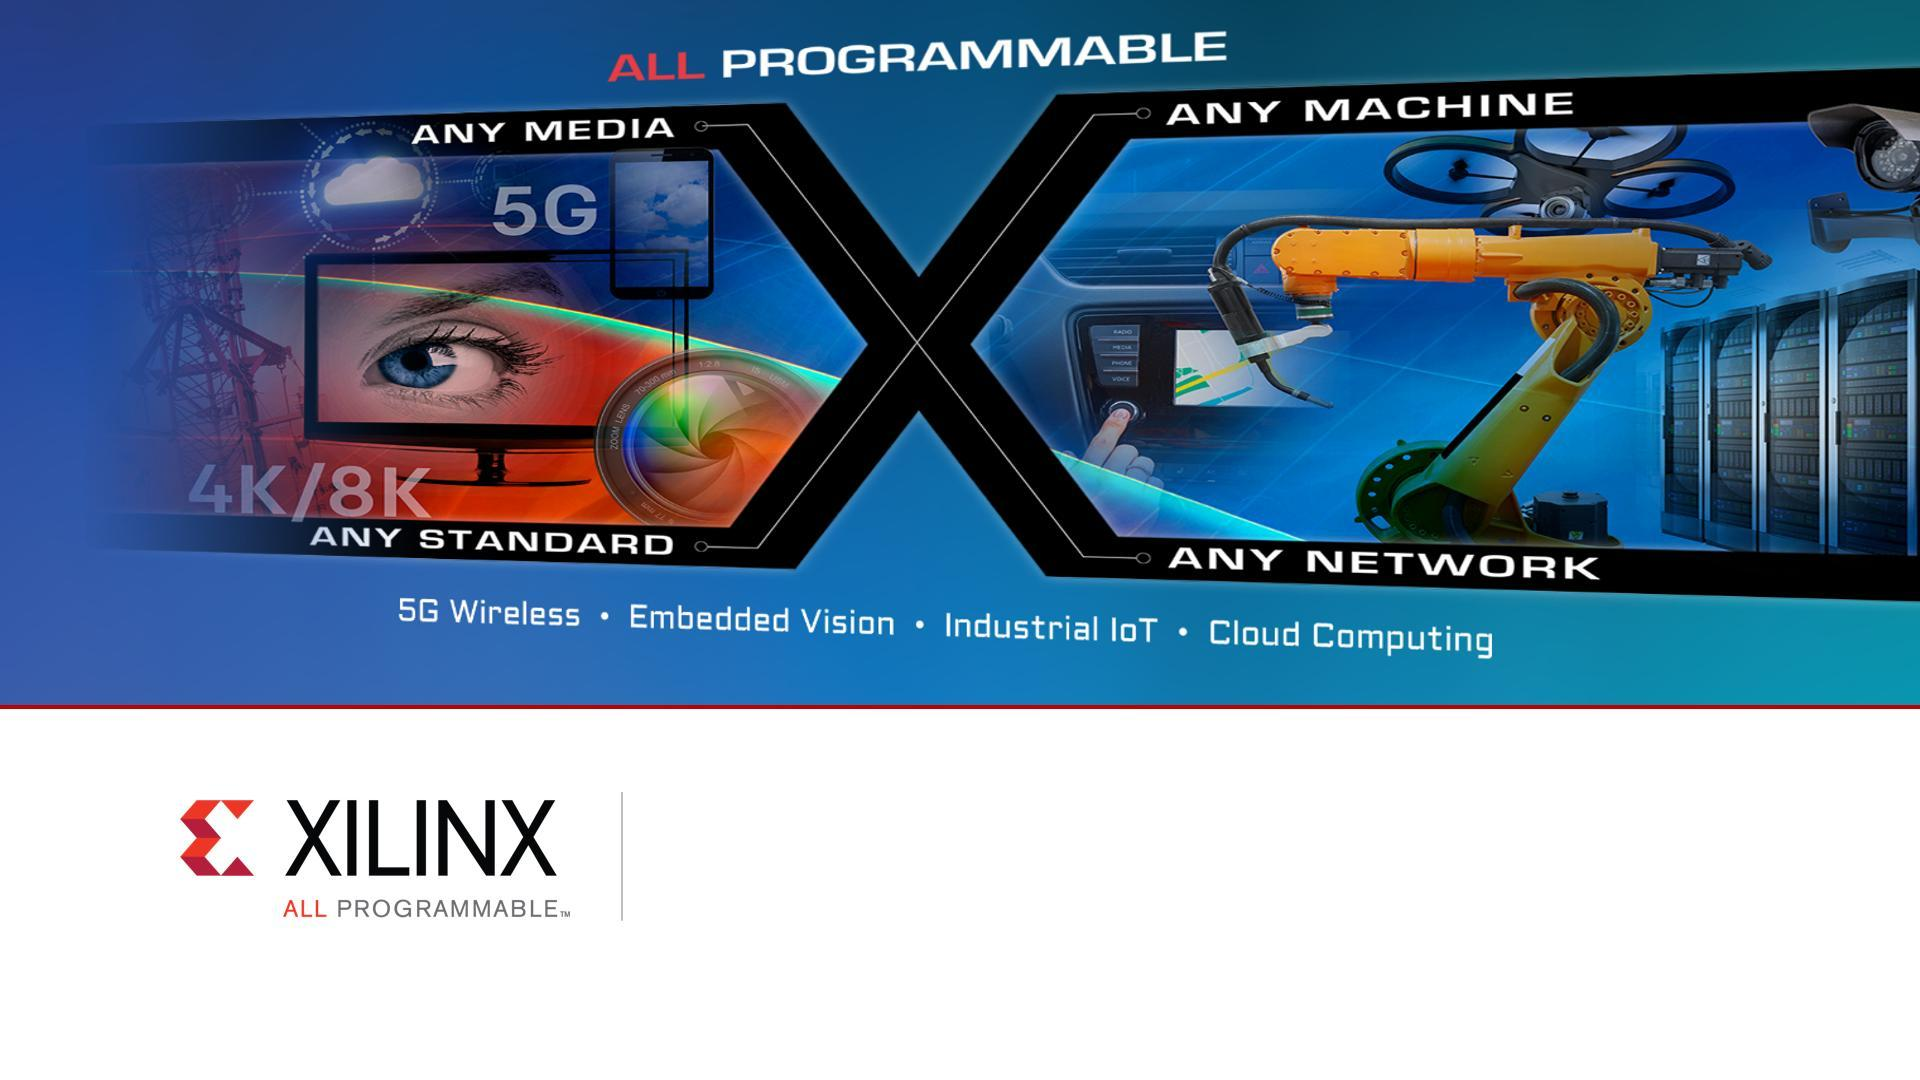

In [2]:
frame = hdmi.frame()
orig_img_path = '/home/xilinx/jupyter_notebooks/examples/data/orig.jpg'
frame.save_as_jpeg(orig_img_path)
Image(filename=orig_img_path)

## 3. Gray Scale filter
This cell should take ~50s to complete. Note that there are better ways (e.g., openCV, etc.) to do grayscale conversion, but this is just an example of doing that without using any additional library.

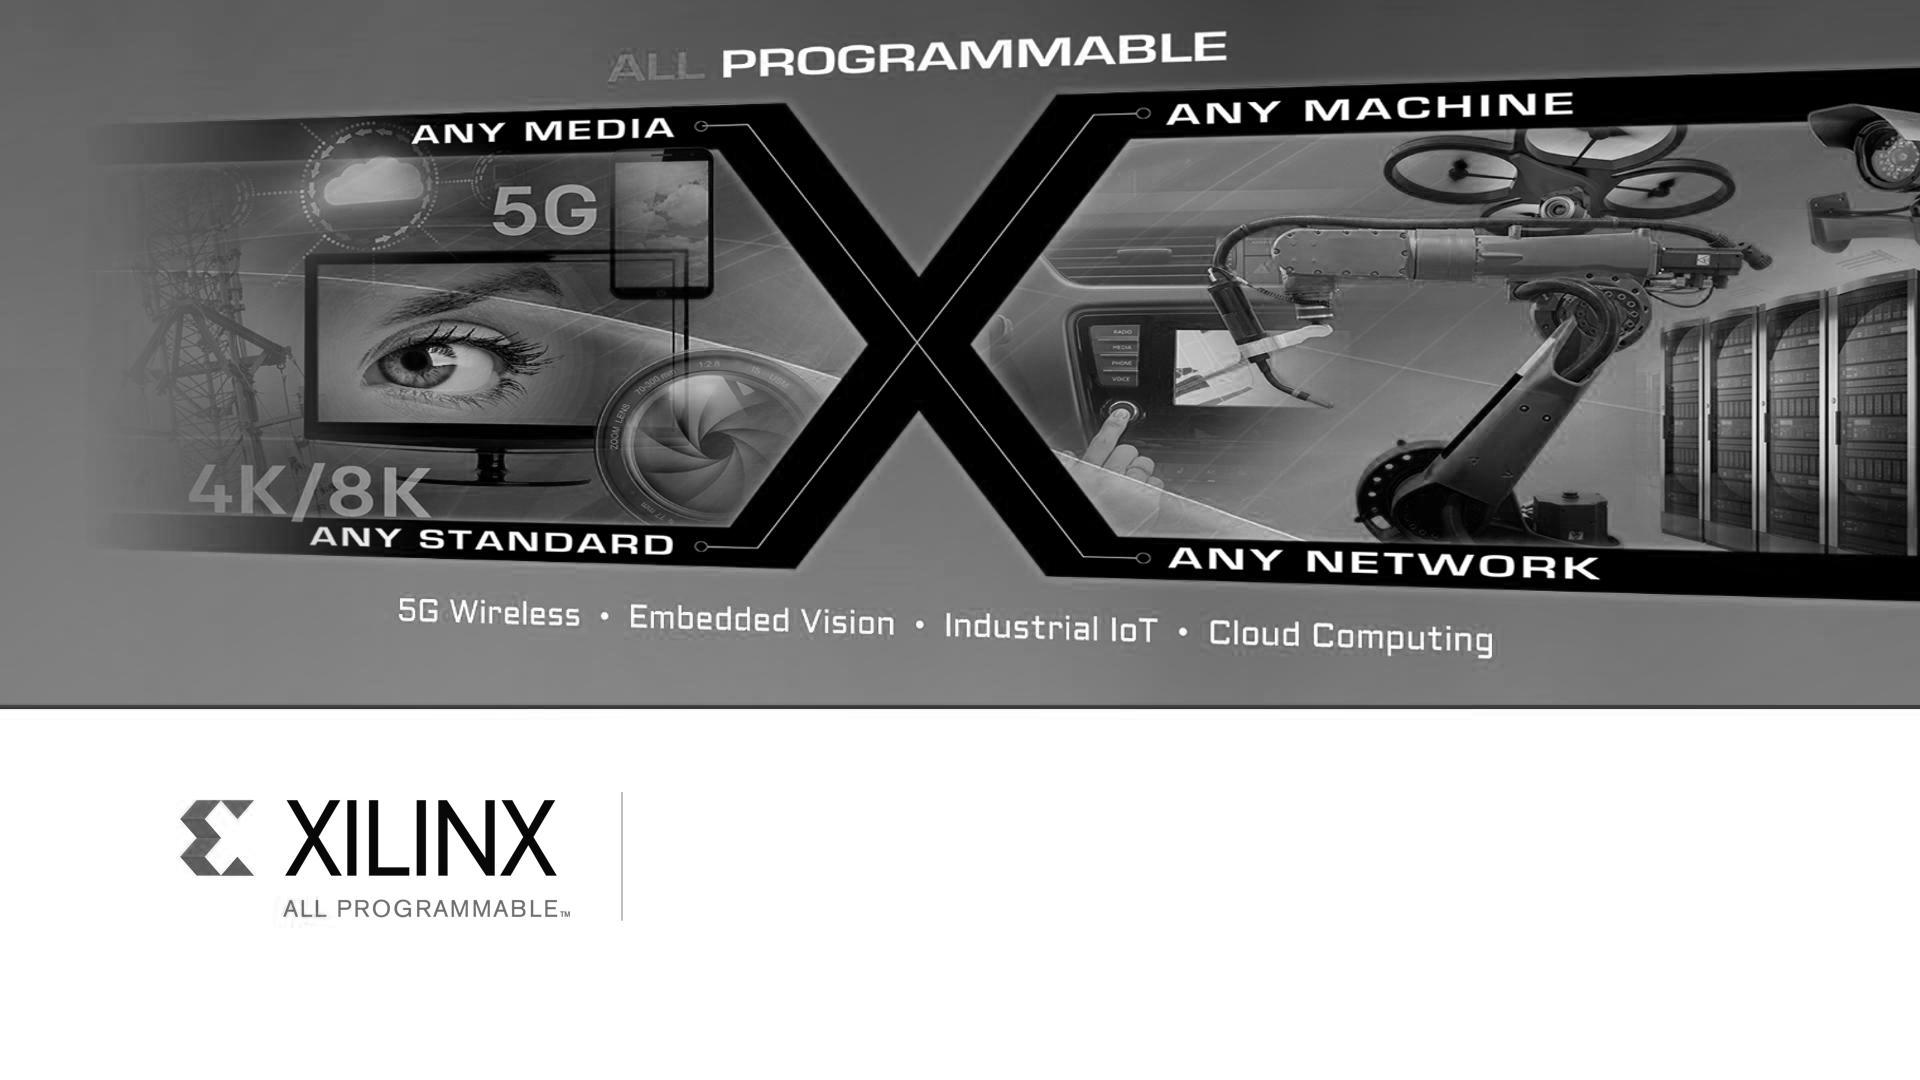

In [3]:
from pynq.drivers.video import MAX_FRAME_WIDTH

frame_i = frame.frame

height = hdmi.frame_height()
width = hdmi.frame_width()

for y in range(0, height):
    for x in range(0, width):
        offset = 3 * (y * MAX_FRAME_WIDTH + x)
        gray = round((0.299*frame_i[offset+2]) + 
                     (0.587*frame_i[offset+0]) +
                     (0.114*frame_i[offset+1]))
        frame_i[offset:offset+3] = gray,gray,gray

gray_img_path = '/home/xilinx/jupyter_notebooks/examples/data/gray.jpg'
frame.save_as_jpeg(gray_img_path)
Image(filename=gray_img_path)

## 4. Sobel filter
This cell should take ~80s to complete. Note that there are better ways (e.g., openCV, etc.) to do sobel filter, but this is just an example of doing that without using any additional library.

Compute the Sobel Filter output with sobel operator:

$G_x=
\begin{bmatrix}
-1 & 0 & +1 \\
-2 & 0 & +2 \\
-1 & 0 & +1
\end{bmatrix}
$

$G_y=
\begin{bmatrix}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix}
$

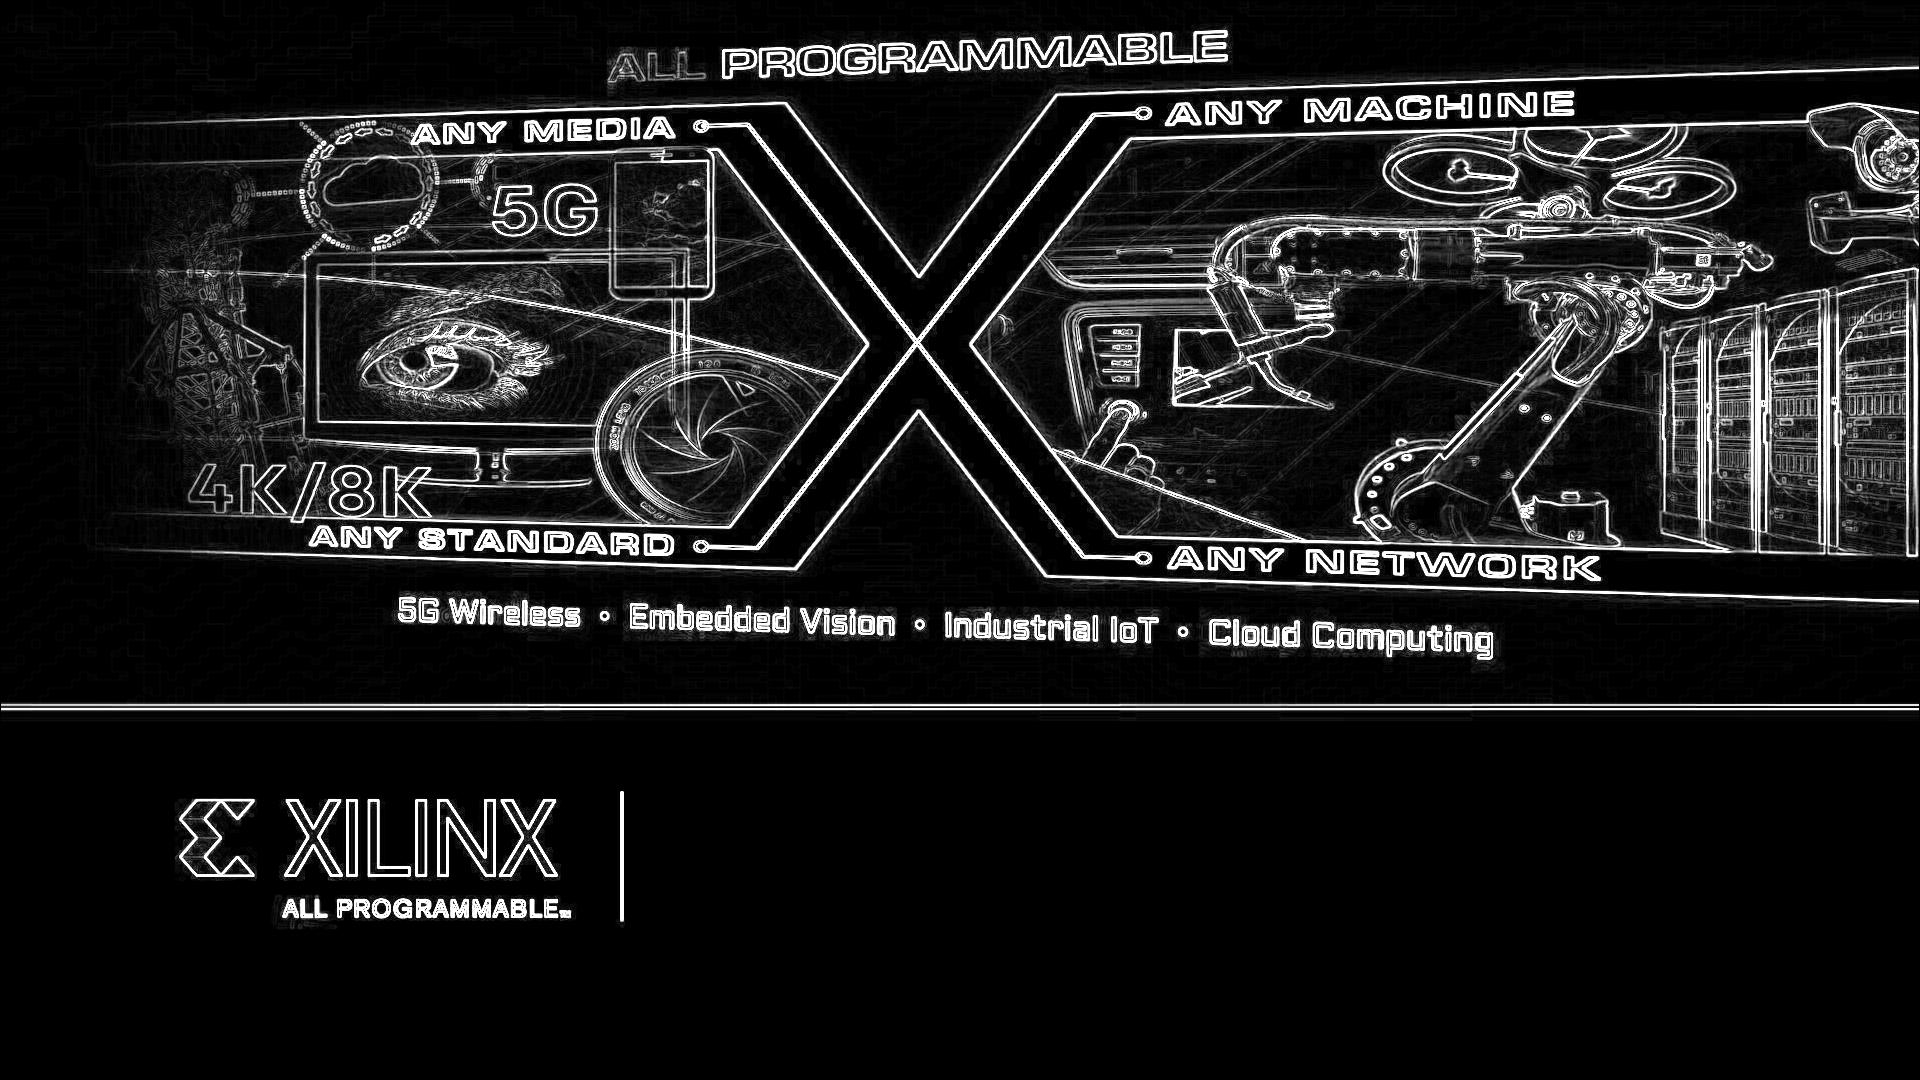

In [4]:
height = 1080
width = 1920
sobel = Frame(1920, 1080)
frame_i = frame.frame

for y in range(1,height-1):
    for x in range(1,width-1):
        offset = 3 * (y * MAX_FRAME_WIDTH + x)
        upper_row_offset = offset - MAX_FRAME_WIDTH*3
        lower_row_offset = offset + MAX_FRAME_WIDTH*3       
        gx = abs(-frame_i[lower_row_offset-3] + frame_i[lower_row_offset+3] -
                 2*frame_i[offset-3] + 2*frame_i[offset+3] -
                 frame_i[upper_row_offset-3] + frame_i[upper_row_offset+3])
        gy = abs(frame_i[lower_row_offset-3] + 2*frame_i[lower_row_offset] + 
                 frame_i[lower_row_offset+3] - frame_i[upper_row_offset-3] -
                 2*frame_i[upper_row_offset] - frame_i[upper_row_offset+3])        
        grad = min(gx + gy,255)              
        sobel.frame[offset:offset+3] = grad,grad,grad
        
sobel_img_path = '/home/xilinx/jupyter_notebooks/examples/data/sobel.jpg'
sobel.save_as_jpeg(sobel_img_path)
Image(filename=sobel_img_path)

## 5: Free up space

In [5]:
hdmi.stop()

del sobel
del hdmi